In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import seaborn as sns

In [55]:
train = pd.read_csv("./data/train.csv", index_col=0)
test = pd.read_csv("./data/test.csv", index_col=0)

# EDA

How does sex affects the different measurements?

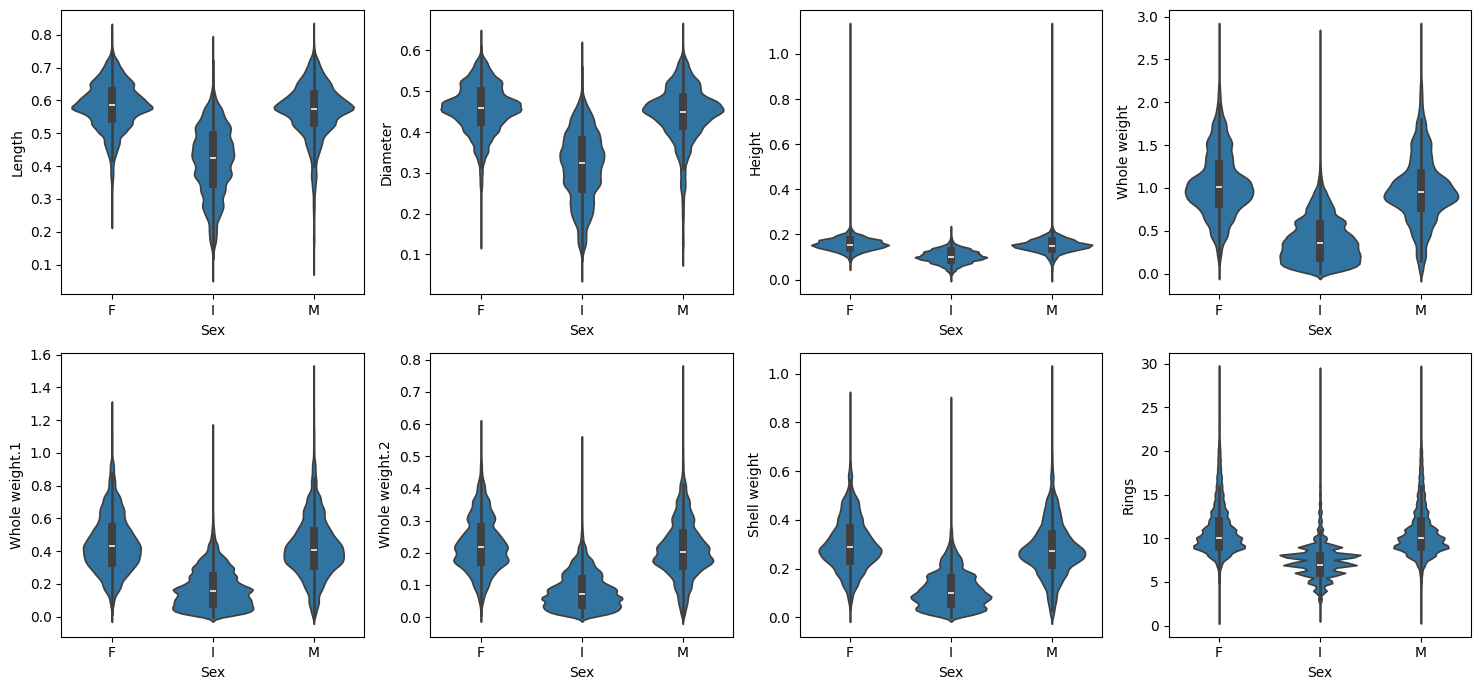

In [43]:
fig, axes = plt.subplots(2, 4, figsize=(15,7))
axes_flat = axes.flatten()
columns = ["Length", "Diameter","Height", "Whole weight", "Whole weight.1", "Whole weight.2", "Shell weight", "Rings"]
for i, ax in enumerate(axes_flat):
    if i < len(columns):
        sns.violinplot(data=train, x="Sex", y=columns[i], ax=ax)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

Which values are correlated witht the number of rings?

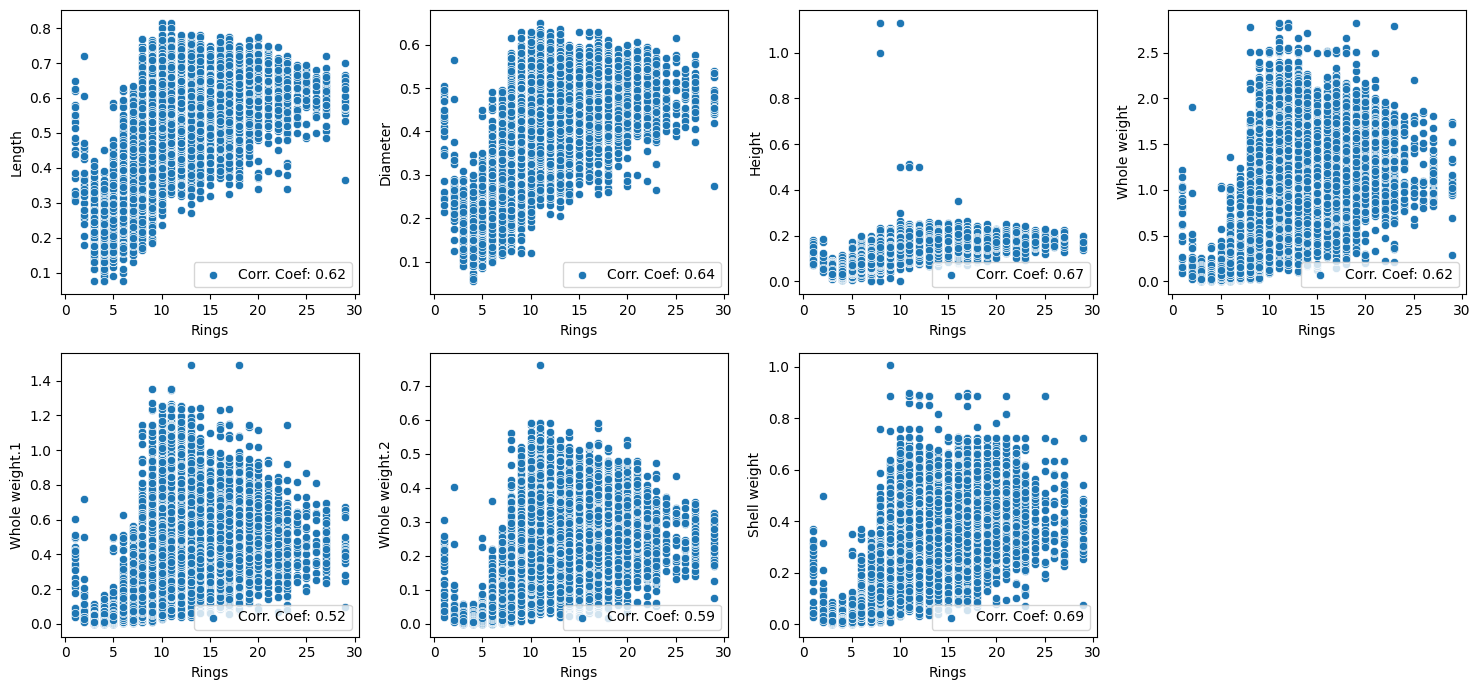

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes_flat = axes.flatten()
columns = ["Length", "Diameter", "Height", "Whole weight", "Whole weight.1", "Whole weight.2", "Shell weight"]

for i, ax in enumerate(axes_flat):
    if i < len(columns):
        sns.scatterplot(data=train, x="Rings", y=columns[i], ax=ax)
        correlation_coefficient = train["Rings"].corr(train[columns[i]])
        ax.legend([f'Corr. Coef: {correlation_coefficient:.2f}'], loc='lower right')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

# Model Training

In [57]:
# For convenience we load the data again
train = pd.read_csv("./data/train.csv", index_col=0)
test = pd.read_csv("./data/test.csv", index_col=0)

In [58]:
train = pd.get_dummies(train, columns=["Sex"], drop_first=True)

In [64]:
train_cols = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Sex_I', 'Sex_M']
X = train[train_cols]
y = train["Rings"]

In [62]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [75]:
assert X_train.index[0] == y_train.index[0]
assert X_val.index[0] == y_val.index[0]

In [78]:
def rmsle_eval(preds, dtrain):
    n = len(preds)
    sum_logs = np.sum(np.power(np.log(1+preds)-np.log(1+dtrain)))
    result = np.sqrt(1/n*sum_logs)
    return result

In [77]:
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('xgb', XGBRegressor())        # XGBoost Regressor
])

# Define hyperparameters for grid search
param_grid = {
    'xgb__n_estimators': [100, 200, 300],      # Number of trees in the forest
    'eval_metric': rmsle_eval,
    'xgb__max_depth': [3, 5, 7],                # Maximum depth of the tree
    'xgb__learning_rate': [0.05, 0.1, 0.2]      # Learning rate
}

# Define cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, evals=[(dtrain, 'train'), (dval, 'val')])
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on validation set
val_score = best_model.score(X_val, y_val)

print("Best parameters found by grid search:")
print(grid_search.best_params_)
print("Validation score:", val_score)

Best parameters found by grid search:
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 300}
Validation score: 0.669384747608634
